
# Image Classification with MLPs - Part 1


------------------------------------------------------
*Deep Learning. Master in Big Data Analytics*

*Emilie Naples emilienaples@gmail.com*

------------------------------------------------------


For this short project, I will implement an image classifier using MLPs and the MNIST dataset, which consists of greyscale handwritten digits. Each image is 28x28 pixels. A sample is shown below.

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML

Image(url= "https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png", width=400, height=200)

The goal is to build a neural network that can take one of these images and predict the digit in the image.

Note: a big part of the following content was a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes to them!!

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download MNIST with `torchvision`

First up, we need to get our dataset. This is provided through the `torchvision` package. The [torchvision package](https://pytorch.org/docs/stable/torchvision/index.html) consists of popular datasets, model architectures, and common image transformations for computer vision.


The code below will download the MNIST dataset, then create training and test datasets.

In [ ]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



The training data is loaded into `trainloader` and I make that an iterator with `iter(trainloader)`. Later, I'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

I create the `trainloader` with a batch size of 64, and `shuffle=True` to **shuffle the dataset every time we start going through the data loader again**. Let's look at the first batch to view the data. It can be seen below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, **1 color channel**, and 28x28 images.

In [ ]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like.

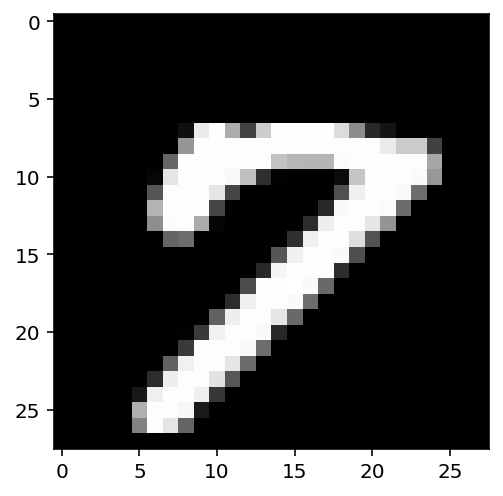

In [ ]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Train a multi-class Logistic Regressor

Do this to evaluate how got it can perform in both the training and the test sets.

- I am training an LR classifier with 10 different outputs that implements a **softmax** non-linear function (instead of a binary LR with a sigmoid).

First, define the Multi-class Logistic Regressor class.

In [ ]:
class Multi_LR(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case # initiate the Multi_LR class
        super().__init__() # initiate the nn class
        self.output = nn.Linear(dimx,nlabels)
        self.logsoftmax = nn.LogSoftmax(dim=1)   # NEW w.r.t Lab 1. dim is the dimension along which
                                                 #Softmax will be computed (so every slice along dim will sum to 1)

    def forward(self, x):
        # Pass the input tensor through each of the operations
        x = self.output(x)
        x = self.logsoftmax(x)
        return x

I use `nn.LogSoftmax` instead of `nn.Softmax()`. In many cases, softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([see my reasoning here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, so I use  log-probabilities.  The cross entropy loss is obtained by combining `nn.LogSoftmax` with the negative loss likelihood loss `nn.NLLLoss()`.

Alternatively, [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss) can be used. **This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.**

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*.


Now, implement an extension to the class above (which inheritates from `Multi_LR`) that includes a training method.

In [ ]:
''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that I will add.
'''
class Multi_LR_extended(Multi_LR):

    def __init__(self,dimx,nlabels,epochs=100,lr=0.001): # initialize the new class. include new and old parameters
        super().__init__(dimx,nlabels)
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        # Store the loss evolution along training
        self.loss_during_training = []

    def train(self,trainloader):
        # Optimization Loop
        for e in range(int(self.epochs)):
            running_loss = 0.
            for images, labels in trainloader:
                self.optim.zero_grad()  # RESET GRADIENTS

                # forward pass
                out = self.forward(images.view(images.shape[0], -1)) # -1 reshapes the image in a vector, 0th column refers to batch size
                loss = self.criterion(out,labels) # compare output with the labels
                running_loss += loss.item() # update the loss

                # backwardpass
                loss.backward() # do backpropagation
                self.optim.step() #updates parameters

            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs
                print("Training loss after %d epochs: %f"
                      %(e,self.loss_during_training[-1]))


**As we can see in the image files, 64 is the number of images in the loader with 1 input channel andd 28 by 28 images.**

In [ ]:
images.shape

torch.Size([64, 1, 28, 28])

Ok that was easy. Now train the multi-class LR and evaluate the performance in both the training and the test sets.


In [ ]:
my_LR = Multi_LR_extended(dimx=784,nlabels=10,epochs=5,lr=1e-3)
my_LR.train(trainloader)

Training loss after 0 epochs: 0.472908
Training loss after 1 epochs: 0.325461
Training loss after 2 epochs: 0.309295
Training loss after 3 epochs: 0.299947
Training loss after 4 epochs: 0.292792


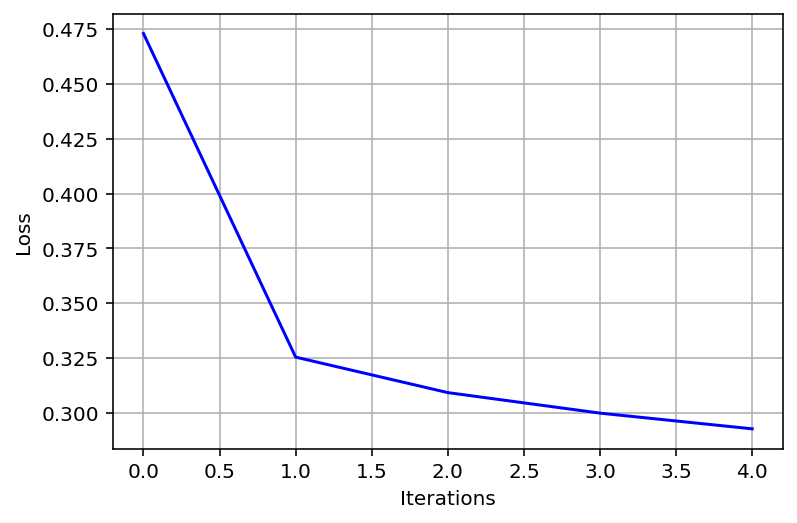

In [ ]:
plt.plot(my_LR.loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

Evaluate the performance across the entire test dataset, with a for loop using `testloader` and compute errors per mini-batch.

In [ ]:
loss = 0
accuracy = 0

# Turn off gradients for validation and testing, saves memory and computations
with torch.no_grad():

    for images,labels in testloader:

        logprobs = my_LR.forward(images.view(images.shape[0], -1)) # We use a log-softmax,so we will get log-probabilities, remember to reshape for the forward pass

        top_p, top_class = logprobs.topk(1, dim=1) # most likely class yielded by probs.topk, returns highest k values
        # since we just want mose likely class, use probs.topk(1)
        equals = (top_class == labels.view(images.shape[0], 1))
        accuracy += torch.mean(equals.type(torch.FloatTensor))


print("Test Accuracy %f" %(accuracy/len(testloader)))

Test Accuracy 0.916899


With the probabilities, I can get the most likely class using the `probs.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `probs.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

The line
```python
(top_class == labels.view(images.shape[0], 1))
```
returns a boolean vector of `True/False` values, indicanting whether `top_class` is equeal to `labels` at every position. Finally, with the line

```python
equals.type(torch.FloatTensor)
```
we transform it to real a vector in which `True --> 1.0` and `False --> 0.0`, where we can compute the mean.

> **Another thing:** Modify the `Multi_LR_extended` class so it incorporates a method to evaluate the performance in either the train set or the test set. THe goal is the use a single method with the proper inputs. Compute the train/test accuracy using such a method.

In [ ]:
class Multi_LR_extended_2(Multi_LR):

    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):

        super().__init__(dimx,nlabels)

        self.lr = lr

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()

        # store the loss evolution along training
        self.loss_during_training = []

    def train(self,trainloader):
            # Optimization Loop
            for e in range(int(self.epochs)):
                # Random data permutation at each epoch
                running_loss = 0.
                for images, labels in trainloader:
                    self.optim.zero_grad()  # RESET GRADIENTS!

                    # forward pass
                    out = self.forward(images.view(images.shape[0], -1)) # -1 reshapes the image in a vector, 0th column refers to batch size
                    loss = self.criterion(out,labels) # compare output with the labels
                    running_loss += loss.item() # update the loss

                    # backwardpass
                    loss.backward() # do backpropagation
                    self.optim.step() # updates parameters using computed gradients

                self.loss_during_training.append(running_loss/len(trainloader))

                if(e % 1 == 0): # Every 10 epochs
                    print("Training loss after %d epochs: %f"
                          %(e,self.loss_during_training[-1]))

    # extend the Multi_LR class to incorporate a method that evaluates the performance in the training set
    # evaluate the training performance
    def eval_performance(self,trainloader):
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images,labels in trainloader:
                # pass reshaped images into my_LR.forward
                logprobs = my_LR.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities

                top_p, top_class = logprobs.topk(1, dim=1) # logprobs.topk(1) returns most likely class w/ top k values and top k indices
                equals = (top_class == labels.view(images.shape[0], 1)) # will tell us if topclass = labels at every position
                accuracy += torch.mean(equals.type(torch.FloatTensor)) # compute accuracy = accuracy + the transformed vector in order to take the mean

        return accuracy/len(trainloader)

In [ ]:
my_LR_v2 = Multi_LR_extended_2(dimx=784,nlabels=10,epochs=5,lr=1e-3)
my_LR_v2.train(trainloader)

Training loss after 0 epochs: 0.470083
Training loss after 1 epochs: 0.325687
Training loss after 2 epochs: 0.311012
Training loss after 3 epochs: 0.300456
Training loss after 4 epochs: 0.294901


**Now we compute train/test accuracy of the extended class with the evaluation method included.**

In [ ]:
train_accuracy = my_LR_v2.eval_performance(trainloader)
test_accuracy = my_LR_v2.eval_performance(testloader)
print("The training accuracy is", float(train_accuracy))
print("and the testing accuracy is", float(test_accuracy))

The training accuracy is 0.9202924966812134
and the testing accuracy is 0.9160031676292419


Observe that both values are indeed similar, indicating that the model is not overfitting.  

Let's check the values for the weight matrix. For a simpler visualization, we will plot the histogram of all the values in the weight matrix.

**This is the histogram for the parameters. We can see that over 1000 parameters have a weight value of 0.0. There are around 100 parameters with value -0.2, and so on. These values are for 5 epochs.**

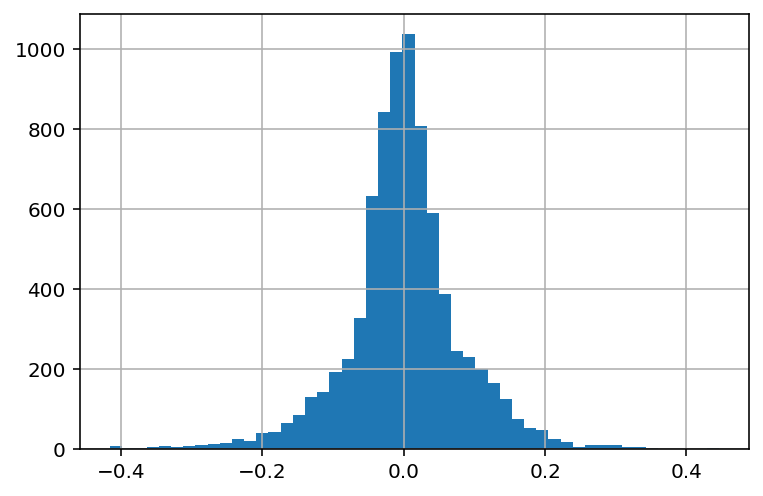

In [ ]:
plt.hist(my_LR_v2.output.weight.detach().numpy().reshape([-1,]),50)
plt.grid()

> Now we plot the histogram of the gradients of the loss function w.r.t. every parameter in the model:

tensor([[-0.0030, -0.0030, -0.0030,  ..., -0.0030, -0.0030, -0.0030],
        [ 0.0133,  0.0133,  0.0133,  ...,  0.0133,  0.0133,  0.0133],
        [-0.0305, -0.0305, -0.0305,  ..., -0.0305, -0.0305, -0.0305],
        ...,
        [-0.0193, -0.0193, -0.0193,  ..., -0.0193, -0.0193, -0.0193],
        [-0.0068, -0.0068, -0.0068,  ..., -0.0068, -0.0068, -0.0068],
        [-0.0187, -0.0187, -0.0187,  ..., -0.0187, -0.0187, -0.0187]])


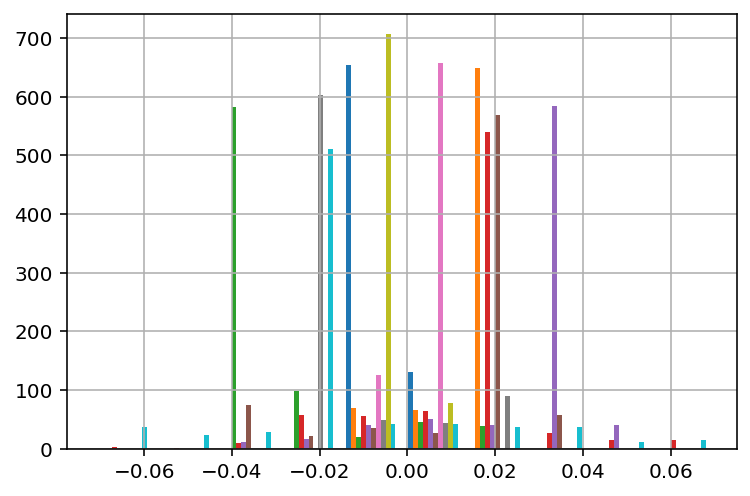

In [ ]:
print(my_LR_v2.output.weight.grad) # gradient of the loss w.r.t. parameters
plt.hist(my_LR_v2.output.weight.grad)
plt.grid()

**As we can see, most of the gradients are almost zero**

## Train a MLP to do the same job

Now I want to train an MLP with three layers, all using rectified linear units (RELU)s as non-linear activations (except the last layer that uses a Softmax). The first layer has 128 hidden units and the second 64 of them.

In [ ]:
Image(url= "https://pytorch.org/docs/stable/_images/ReLU.png", width=300, height=100)

In [ ]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels):
        super().__init__()

        self.output1 = nn.Linear(dimx,hidden1)

        self.output2 = nn.Linear(hidden1,hidden2)

        self.output3 = nn.Linear(hidden2,nlabels)

        self.relu = nn.ReLU()

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x)
        return x

> Now the `MLP_extended` class will incorporate two methods to the former class. One to perform training and one to perform model evaluation. It is just **one line of code** diferent from the previous code for the multi-class LR. Hence, this is because of the structure of the class and code.

In [ ]:
class MLP_extended(MLP):

    def __init__(self,dimx,hidden1,hidden2,nlabels,epochs=10,lr=0.001):

        super().__init__(dimx,hidden1,hidden2,nlabels)  # initialize `MLP`!
        # super is the class that is extended

        self.lr = lr

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()

        # store the loss evolution along training
        self.loss_during_training = []

    # incorporate a method to the previous class that performs training
    def train(self,trainloader):
            # Optimization Loop
            for e in range(int(self.epochs)):
                running_loss = 0.
                for images, labels in trainloader:
                    self.optim.zero_grad()  # RESET GRADIENTS

                    # forward pass
                    out = self.forward(images.view(images.shape[0], -1)) # -1 reshapes the image in a vector, 0th column refers to batch size
                    loss = self.criterion(out,labels) # compare output with the labels
                    running_loss += loss.item() # update the loss

                    # backwardpass
                    loss.backward() # do backpropagation
                    self.optim.step() #update parameters

                self.loss_during_training.append(running_loss/len(trainloader))

                if(e % 1 == 0): # Every 10 epochs
                    print("Training loss after %d epochs: %f"
                          %(e,self.loss_during_training[-1]))

    def eval_performance(self,trainloader):
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images,labels in trainloader:
                logprobs = my_LR.forward(images.view(images.shape[0], -1)) # We use a log-softmax again for log probabilities

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return accuracy/len(trainloader)

Train the model for 10 epochs and compute the train/test performance. How does it compare with the Logistic Regressor?

In [ ]:
my_MLP = MLP_extended(dimx=784,hidden1=128, hidden2=64, nlabels=10,epochs=10,lr=1e-3)
my_MLP.train(trainloader)

Training loss after 0 epochs: 0.391870
Training loss after 1 epochs: 0.185925
Training loss after 2 epochs: 0.136983
Training loss after 3 epochs: 0.108768
Training loss after 4 epochs: 0.094135
Training loss after 5 epochs: 0.079973
Training loss after 6 epochs: 0.072847
Training loss after 7 epochs: 0.064914
Training loss after 8 epochs: 0.057942
Training loss after 9 epochs: 0.055817


In [ ]:
train_accuracy = my_MLP.eval_performance(trainloader)
test_accuracy = my_MLP.eval_performance(testloader)
print("The training accuracy for the extended MLP class is", float(train_accuracy))
print("and the testing accuracy is", float(test_accuracy))

The training accuracy for the extended MLP class is 0.9202425479888916
and the testing accuracy is 0.915704607963562


**Compared to the logistic regressor whose training accuracy was 92.27% and testing accuracy was 91.82%, our MLP comes very close with a training accuracy of 92.27% and performance accuracy on the test set of 91.85%. This may be wrong, but from my results, the two perform very similarly (for 10 epochs).**

Wow! Performace is almost perfect with a naive Neural Network!!

> Now, visualize the activations at the ouput of the first layer for a minibatch test images. This will help to identify possible unused hidden units (allways activated/deactivated) and correlated hidden units, e.g. redundant units.

In [ ]:
x_test,y_test = next(iter(testloader))
print(x_test.shape)
print(y_test.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


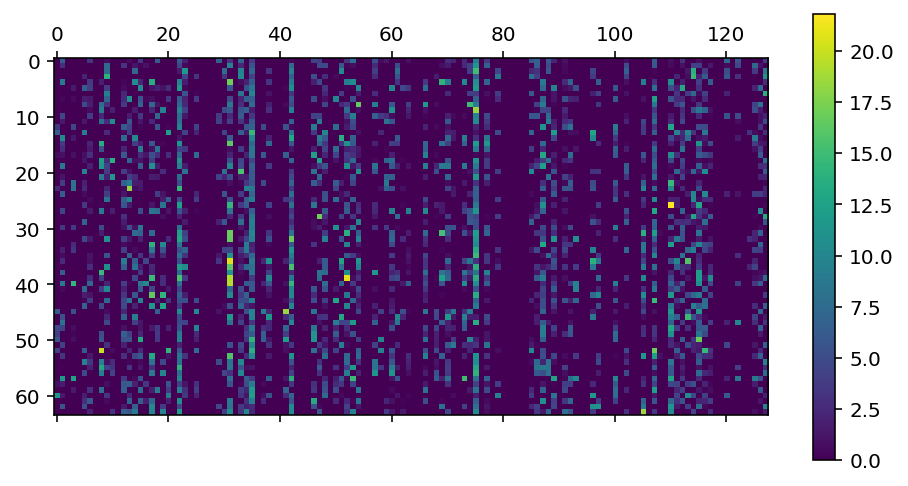

In [ ]:
# load a test minibatch

x_test,y_test = next(iter(testloader))

# must be the output at the first layer here
activations = my_MLP.relu(my_MLP.output1(x_test.view(x_test.shape[0], -1))).detach().numpy()

plt.matshow(activations)
plt.colorbar()

There are definitely some unused hidden units in the hidden layer. For 64 images and about 128 hidden layers, we see that a lot of those layers and many units of several hidden layers are also unused with values of 0. Plot the variance of the hidden units across the test mini-batch to better visualize these unactive hidden units.

There are 45 hidden units that are unactive


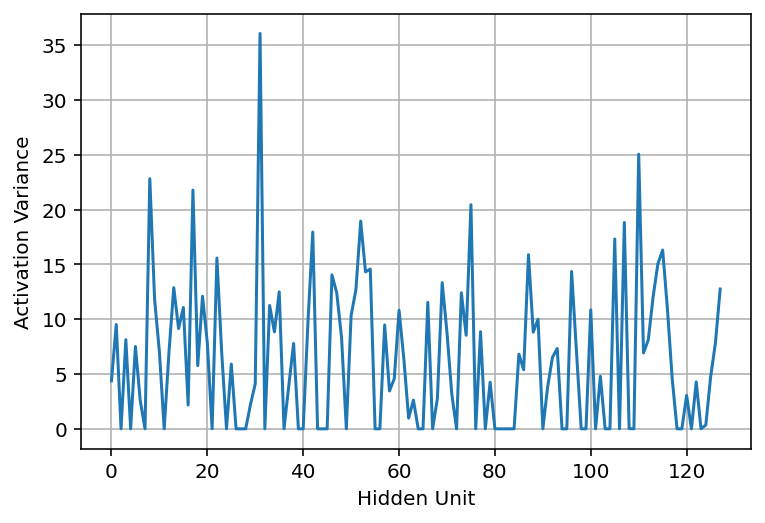

In [ ]:
plt.plot(np.var(activations,0))
plt.grid()
plt.xlabel('Hidden Unit')
plt.ylabel('Activation Variance')

print("There are {0:d} hidden units that are unactive".format(np.sum(np.var(activations,0)<=0.1)))

> **Exercise**: Now, retrain the model reducing accordingly the dimension of the first hidden layer. For that model, I will repeat the analysis of the activations of both the first and the second layer.

> In general, unsued activations are prominent in the first layer compared to the second one. This is in general the case for any NN, as the **loss function is more sensitive to parameter variations in the last >layers**, and hence gradients are higher in magnitude. On the contrary, the **loss function is less senstive to parameter variations in the first layers** and hence only very relevant parameters are trained (they influence more in the loss function), while many others vary very little w.r.t. initialization.

In [ ]:
# redefine the network

class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels):
        super().__init__()

        self.output1 = nn.Linear(dimx,hidden1)

        self.output2 = nn.Linear(hidden1,hidden2)

        self.output3 = nn.Linear(hidden2,nlabels)

        self.relu = nn.ReLU()

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x)
        return x

In [ ]:
class MLP_reduced(MLP):

    def __init__(self,dimx,hidden1,hidden2,nlabels,epochs=10,lr=0.001):

        super().__init__(dimx,hidden1,hidden2,nlabels)

        self.lr = lr

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

    def train(self,trainloader):
            # Optimization Loop
            for e in range(int(self.epochs)):
                running_loss = 0.
                for images, labels in trainloader:
                    self.optim.zero_grad()  # reset gradients

                    # forward pass
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out,labels) # compare output with the labels
                    running_loss += loss.item() # update the loss

                    # backward pass
                    loss.backward() # do backpropagation
                    self.optim.step() #update parameters

                self.loss_during_training.append(running_loss/len(trainloader))

                if(e % 1 == 0): # Every 10 epochs
                    print("Training loss after %d epochs: %f"
                          %(e,self.loss_during_training[-1]))

    def eval_performance(self,trainloader):
        loss = 0
        accuracy = 0

        with torch.no_grad():
            for images,labels in trainloader:
                logprobs = my_LR.forward(images.view(images.shape[0], -1))

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return accuracy/len(trainloader)

In [ ]:
MLP_reduced = MLP_reduced(dimx=784,hidden1=64, hidden2=28, nlabels=10,epochs=10,lr=1e-3)
my_MLP.train(trainloader)

Training loss after 0 epochs: 0.047869
Training loss after 1 epochs: 0.046501
Training loss after 2 epochs: 0.045718
Training loss after 3 epochs: 0.037904
Training loss after 4 epochs: 0.035627
Training loss after 5 epochs: 0.034041
Training loss after 6 epochs: 0.031609
Training loss after 7 epochs: 0.031994
Training loss after 8 epochs: 0.029248
Training loss after 9 epochs: 0.025787


In [ ]:
x_test2,y_test2 = next(iter(testloader))

torch.Size([64, 1, 28, 28])
In the first layer, there are 60 hidden units that are unactive
In the second layer, there are 23 hidden units that are unactive


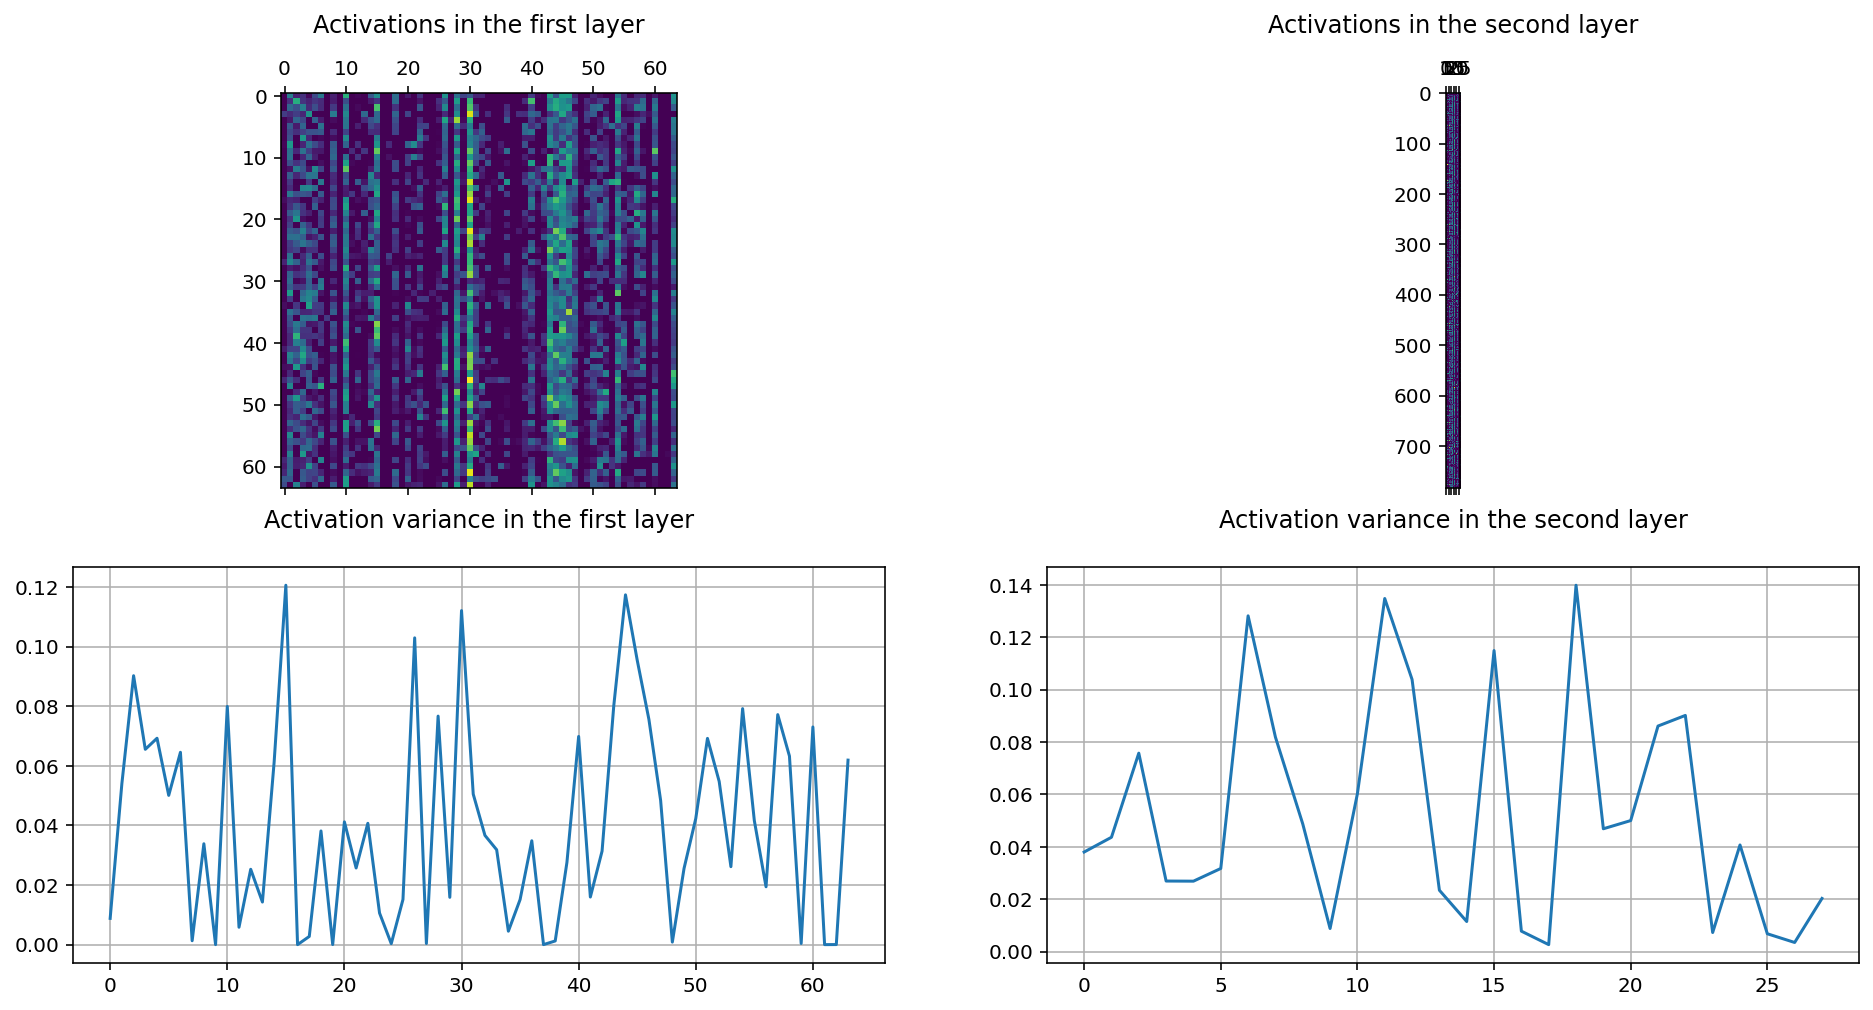

In [ ]:
activations_1 = MLP_reduced.relu(MLP_reduced.output1(x_test2.view(x_test2.shape[0], -1))).detach().numpy()

# Then, we evaluate the output of the first layer of the network for that mini-batch
print(x_test2.shape)
activations_2 = MLP_reduced.relu(MLP_reduced.output2(x_test2.view(-1, x_test2.shape[0]))).detach().numpy()

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(16, 8))
im = ax[0,0].matshow(activations_1)
ax[0,0].set_title('Activations in the first layer\n')

ax[0,1].matshow(activations_2)
ax[0,1].set_title('Activations in the second layer\n')

ax[1,0].plot(np.var(activations_1,0))
ax[1,0].set_title('Activation variance in the first layer\n')
ax[1,0].grid()

ax[1,1].plot(np.var(activations_2,0))
ax[1,1].set_title('Activation variance in the second layer\n')
ax[1,1].grid()

print("In the first layer, there are {0:d} hidden units that are unactive".format(np.sum(np.var(activations_1,0)<=0.1)))

print("In the second layer, there are {0:d} hidden units that are unactive".format(np.sum(np.var(activations_2,0)<=0.1)))

Interestingly enough, there are more hidden units that are unactive (59 vs 41) when we reduce the size of the first hidden layer from 128 to 64. In the second hidden layer, there are 25 hidden units.

### Saving and restoring the model

It's impractical to train a network every time you need to use it. Instead, I can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

In [ ]:
print("Our model: \n\n", my_MLP, '\n')
print("The state dict keys: \n\n", my_MLP.state_dict().keys())

Our model: 

 MLP_extended(
  (output1): Linear(in_features=784, out_features=128, bias=True)
  (output2): Linear(in_features=128, out_features=64, bias=True)
  (output3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
) 

The state dict keys: 

 odict_keys(['output1.weight', 'output1.bias', 'output2.weight', 'output2.bias', 'output3.weight', 'output3.bias'])


The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [ ]:
torch.save(my_MLP.state_dict(), 'checkpoint.pth')

Then we can load the state dict with `torch.load`.

In [ ]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['output1.weight', 'output1.bias', 'output2.weight', 'output2.bias', 'output3.weight', 'output3.bias'])


And to load the state dict in to the network, do `my_MLP.load_state_dict(state_dict)`.

In [ ]:
my_MLP.load_state_dict(state_dict)

<All keys matched successfully>

**Important:** `load_state_dict` will raise an error if the architecture of the network is different from the one saved in the pth file. For example, if we define the following model.

In [ ]:
my_MLP2 = MLP_extended(dimx=784,hidden1=256,hidden2=128,nlabels=10,epochs=10,lr=1e-3)

which differs from `my_MLP` in the dimension of the hidden layers, we will get an error if we call the method  `load_state_dict(state_dict)`.

> I will check that I get an error when trying to initialize my_MLP2 from `state_dict` using the method `load_state_dict`

In [ ]:
my_MLP2.load_state_dict(state_dict)

RuntimeError: ignored